## Numerical Exercises 1
James Dunstan

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.special import legendre

## Question 4

Based on the textbook by Morton (pg.11) the explicit scheme for the diffusion equation $u_t = u_{xx}$ is given by $$U_j^{n + 1} = U_{j}^{n} + \mu(U_{j+1}^{n} -2U_j^{n} + U_{j-1}^{n}).$$ Since there is one unknown for each equation we do not need a matrix and instead we can add the unknown values $U_j^{n+1}$ to an array for the timestep $n+1$ and then use this as the initial condition for the next timestep $n+2$. First we define the intitial condition given by Morton as follows:

In [6]:
def u_0(x): # function defining the initial condition
    if 0<= x <= 0.5:
        u = 2*x
    elif 0.5 < x <= 1:
        u = 2 - 2*x

    return(u)

#note that the boundary conditions are automatically satisfied by this initial condition.

Then we carry out the explicit scheme, using the same parameter values as Morton, in the code below:

In [8]:
def question_4(timestep,n):
    J = 20
    dx = 1 / J # spatial stepsize
    dt = timestep # time stepsize
    mu = dt / ((dx)**2) 
    final_time = n*dt # at what time we want to stop the scheme and output the u-array
    
    u0 = np.zeros(J+1)
    for i in range(J+1): # define the initial condition array
        u0[i] = u_0(i*dx) # referencing the function above
    
    u_old = u0.copy()
    u_new = np.zeros(J+1) # define an array for the unknown points at the next time step up. note the first and last positions can stay as zeros. 
    
    k = dt
    while k < final_time: #time loop 
        for i in  range(1,J):
            u_new[i] = u_old[i] + mu*(u_old[i+1] - 2*u_old[i] + u_old[i-1])
        u_new[0] = 0 # setting boundary conditions
        u_new[-1] = 0

        u_old = u_new.copy()
        k+=dt

    return(u_old)
    
    

and reproduce figure 2.2 from the Morton textbook:

Text(0, 0.5, 'u(x,t)')

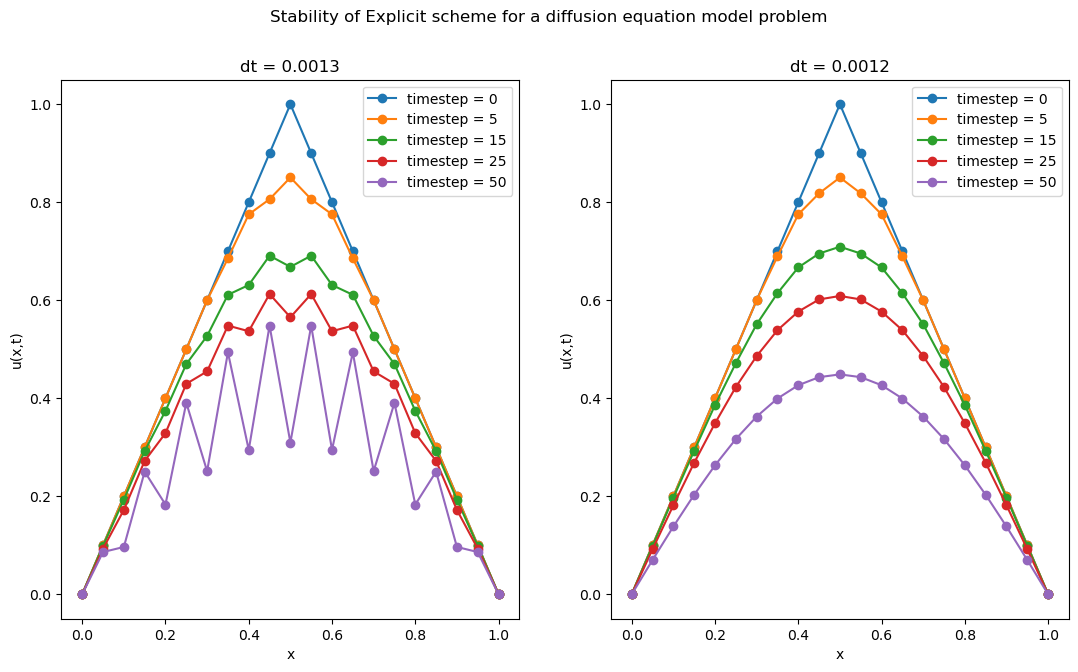

In [10]:
x = np.linspace(0,1,21)
y1 = question_4(0.0013, 0)
y2 = question_4(0.0013, 5)
y3 = question_4(0.0013, 15)
y4 = question_4(0.0013, 25)
y5 = question_4(0.0013, 50)

y6 = question_4(0.0012, 0)
y7 = question_4(0.0012, 5)
y8 = question_4(0.0012, 15)
y9 = question_4(0.0012, 25)
y10 = question_4(0.0012, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
fig.suptitle('Stability of Explicit scheme for a diffusion equation model problem')
ax1.plot(x, y1, marker ='o', label='timestep = 0')
ax1.plot(x,y2, marker ='o', label='timestep = 5')
ax1.plot(x,y3, marker ='o',label='timestep = 15')
ax1.plot(x,y4, marker ='o',label='timestep = 25')
ax1.plot(x,y5, marker ='o',label='timestep = 50')
ax1.set_title('dt = 0.0013')
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')
         
ax2.plot(x,y6, marker ='o', label='timestep = 0')
ax2.plot(x,y7, marker ='o',label='timestep = 5')
ax2.plot(x,y8, marker ='o',label='timestep = 15')
ax2.plot(x,y9, marker ='o',label='timestep = 25')
ax2.plot(x,y10, marker ='o',label='timestep = 50')
ax2.set_title('dt = 0.0012')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,t)')

We can look at the stability properties of the explicit scheme by performing a fourier analysis and looking at the maximum principle. This is done on paper in the file attached under question 4. 

## Question 5

We now move onto the $\theta$-scheme, whose discretisation for the linear advection-diffusion equation has already been written out in the handwritten attatchment under question 3. Below we implement the $\theta$-scheme for the same initial condition as in question 4.  

In [13]:
def question_5(timestep,t,a,epsilon,theta):
    J = 20
    n = J+1
    dx = 1 / J # spatial stepsize
    dt = t # time stepsize
    k1 = dt*a / (dx) # constants as defined in handwritten attatchment
    k2 = dt*epsilon / ((dx)**2)
    final_time = timestep*dt # at what time we want to stop the scheme and output the u-array
    left_boundary = 0 # boundary conditions
    right_boundary = 0

    A = np.zeros((n-2,n-2)) # define the A Matrix
    b = np.zeros(n-2) # Define the b-vector
    
    u0 = np.zeros(n)
    for i in range(n): # define the initial condition array
        u0[i] = u_0(i*dx) # references function above from question 4

    u_old = u0.copy()
    
    s1 = np.ones(n-3)*(theta*(-k1 - k2)) # simplify coefficients to more easily generate the A matrix
    s2 = np.ones(n-2)*(1 + theta*(k1 + 2*k2))
    s3 = np.ones(n-3)*(-k2*theta)
    q1 = k1 - k1*theta + k2 - k2*theta
    q2 = 1 - k1 + k1*theta - 2*k2 + 2*k2*theta
    q3 = k2*(1-theta)

    
    A = diags([s2,s3,s1], [0,1,-1]) # generate the A-matrix using a scipy function which creates tridiaginal matrices


    k = dt
    while k < final_time:      # the time loop implements the scheme by solving the Ax = b matrix equation using a python linear algebra solver, then
        for i in range(n-2):   # updating the b-vector with the x-vector solution. 
            b[i] = q3*u_old[i] + q2*u_old[i+1] + q1*u_old[i+2]
      
        b[0] += left_boundary*k2*theta # boundary conditions are added in after the fact for the two points near the boundaries
        b[n-3] += right_boundary*theta*(k1+k2)
    
        solution = spsolve(A,b)
        u_old[1:-1] = solution
        k+=dt
    
    return(u_old)
    

To test the $\theta$-scheme we can recreate the plots from question 4 by setting $\theta = 0$, since this would reduce the scheme to an explicit scheme. We can also set the 'a' parameter to 0 and 'epsilon' to 1 to recreate the diffusion equation. The results below confirm that the code is correct:

C:\Users\mm21jd\AppData\Local\Temp\ipykernel_16644\1481500910.py:40: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A,b)


Text(0, 0.5, 'u(x,t)')

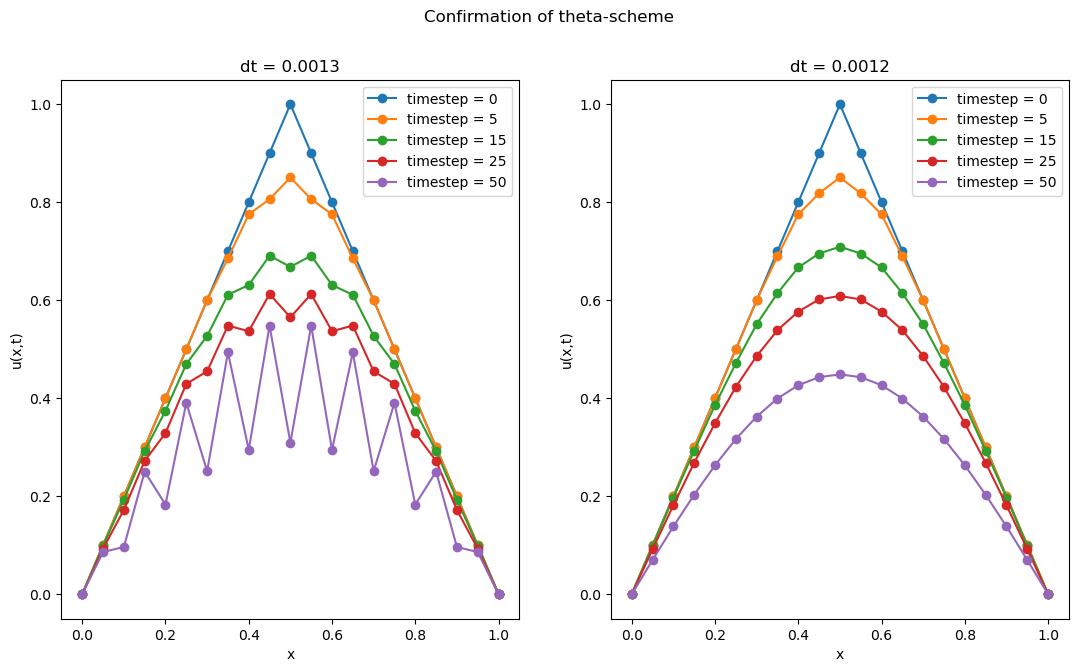

In [15]:
x = np.linspace(0,1,21)
p1 = question_5(0,0.0013, 0,1,0)
p2 = question_5(5,0.0013, 0,1,0)
p3 = question_5(15, 0.0013, 0,1,0)
p4 = question_5(25,0.0013, 0,1,0)
p5 = question_5(50, 0.0013, 0,1,0)

p6 = question_5(0,0.0012, 0,1,0)
p7 = question_5(5,0.0012, 0,1,0)
p8 = question_5(15, 0.0012, 0,1,0)
p9 = question_5(25,0.0012, 0,1,0)
p10 = question_5(50, 0.0012, 0,1,0)

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13,7))
fig.suptitle('Confirmation of theta-scheme')
ax3.plot(x, p1, marker ='o', label='timestep = 0')
ax3.plot(x,p2, marker ='o', label='timestep = 5')
ax3.plot(x,p3, marker ='o',label='timestep = 15')
ax3.plot(x,p4, marker ='o',label='timestep = 25')
ax3.plot(x,p5, marker ='o',label='timestep = 50')
ax3.set_title('dt = 0.0013')
ax3.legend()
ax3.set_xlabel('x')
ax3.set_ylabel('u(x,t)')
         
ax4.plot(x,p6, marker ='o', label='timestep = 0')
ax4.plot(x,p7, marker ='o',label='timestep = 5')
ax4.plot(x,p8, marker ='o',label='timestep = 15')
ax4.plot(x,p9, marker ='o',label='timestep = 25')
ax4.plot(x,p10, marker ='o',label='timestep = 50')
ax4.set_title('dt = 0.0012')
ax4.legend()
ax4.set_xlabel('x')
ax4.set_ylabel('u(x,t)')

If we set the 'a' parameter to 1 we can extend the explicit scheme to the linear advection-diffusion equation and again plot the results below:

C:\Users\mm21jd\AppData\Local\Temp\ipykernel_16644\1481500910.py:40: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A,b)


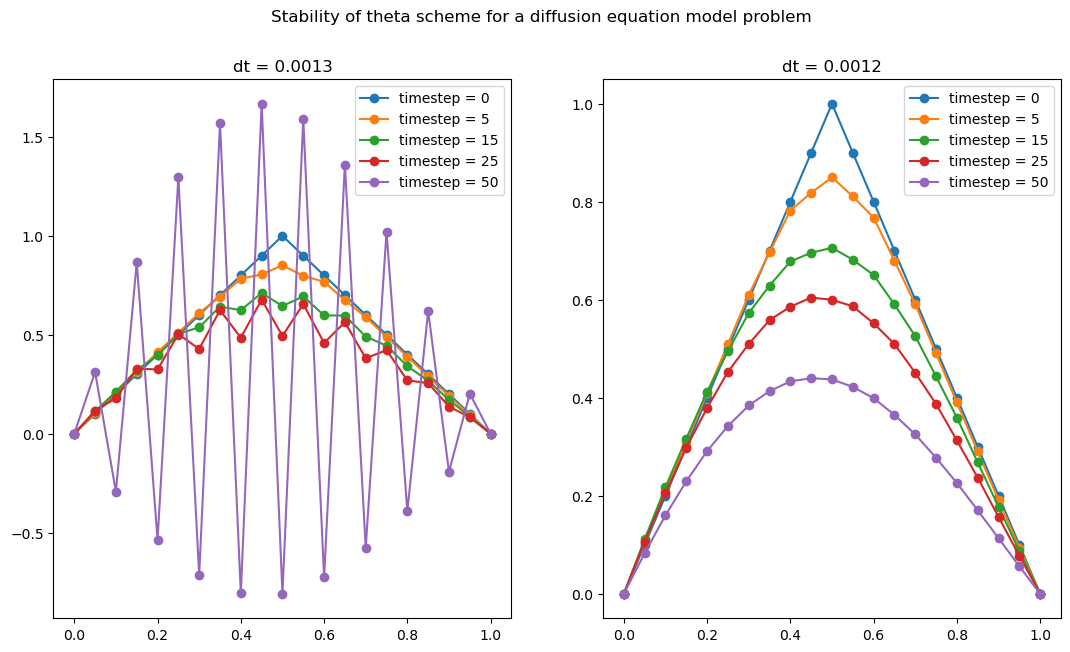

In [48]:
x = np.linspace(0,1,21)
r1 = question_5(0,0.0013, 1,1,0)
r2 = question_5(5,0.0013, 1,1,0)
r3 = question_5(15, 0.0013, 1,1,0)
r4 = question_5(25,0.0013, 1,1,0)
r5 = question_5(50, 0.0013, 1,1,0)

r6 = question_5(0,0.0012, 1,1,0)
r7 = question_5(5,0.0012, 1,1,0)
r8 = question_5(15, 0.0012, 1,1,0)
r9 = question_5(25,0.0012, 1,1,0)
r10 = question_5(50, 0.0012, 1,1,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
fig.suptitle('Stability of theta scheme for a diffusion equation model problem')
ax1.plot(x, r1, marker ='o', label='timestep = 0')
ax1.plot(x,r2, marker ='o', label='timestep = 5')
ax1.plot(x,r3, marker ='o',label='timestep = 15')
ax1.plot(x,r4, marker ='o',label='timestep = 25')
ax1.plot(x,r5, marker ='o',label='timestep = 50')
ax1.set_title('dt = 0.0013')
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')
         
ax2.plot(x,r6, marker ='o', label='timestep = 0')
ax2.plot(x,r7, marker ='o',label='timestep = 5')
ax2.plot(x,r8, marker ='o',label='timestep = 15')
ax2.plot(x,r9, marker ='o',label='timestep = 25')
ax2.plot(x,r10, marker ='o',label='timestep = 50')
ax2.set_title('dt = 0.0012')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,t)')

As we can see above the scheme for $dt = 0.0013$ is unstable whereas for $dt = 0.0012$ it appears stable just like we found for the pure diffusion equation used in question 4. Looking at the fourier analysis in the handwritten attatchment under question 5 we can see that for a purely diffusive theta-scheme we have stability when $\frac{1}{2} \leq \theta \leq 1$ for any value of $\mu$ and stability for  $0 \leq \theta \leq \frac{1}{2}$ if and only if $ \mu \leq \frac{1}{2(1-2 \theta)}.$ We can test this by plotting the theta scheme for $\theta = 0.25$ and hence stability occurs when $\mu \leq 1.$ Since in the diffusive equation we have $\mu = \frac{ \epsilon dt}{dx^2}$ we can choose values of dt and dx to straddle this boundary.

C:\Users\mm21jd\AppData\Local\Temp\ipykernel_16644\1481500910.py:40: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A,b)


Text(0, 0.5, 'u(x,t)')

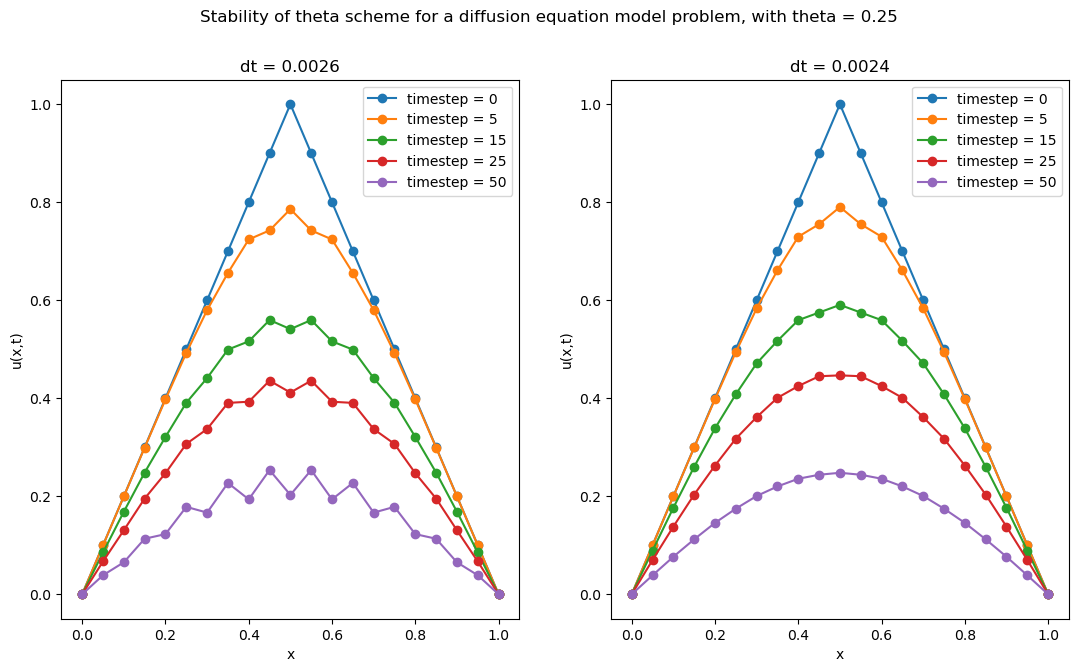

In [67]:
x = np.linspace(0,1,21)
r1 = question_5(0,0.0026, 0,1,0.25)
r2 = question_5(5,0.0026, 0,1,0.25)
r3 = question_5(15, 0.0026, 0,1,0.25)
r4 = question_5(25,0.0026, 0,1,0.25)
r5 = question_5(50, 0.0026, 0,1,0.25)

r6 = question_5(0,0.0024, 0,1,0.25)
r7 = question_5(5,0.0024, 0,1,0.25)
r8 = question_5(15, 0.0024, 0,1,0.25)
r9 = question_5(25,0.0024, 0,1,0.25)
r10 = question_5(50, 0.0024, 0,1,0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
fig.suptitle('Stability of theta scheme for a diffusion equation model problem, with theta = 0.25')
ax1.plot(x, r1, marker ='o', label='timestep = 0')
ax1.plot(x,r2, marker ='o', label='timestep = 5')
ax1.plot(x,r3, marker ='o',label='timestep = 15')
ax1.plot(x,r4, marker ='o',label='timestep = 25')
ax1.plot(x,r5, marker ='o',label='timestep = 50')
ax1.set_title('dt = 0.0026')
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')
         
ax2.plot(x,r6, marker ='o', label='timestep = 0')
ax2.plot(x,r7, marker ='o',label='timestep = 5')
ax2.plot(x,r8, marker ='o',label='timestep = 15')
ax2.plot(x,r9, marker ='o',label='timestep = 25')
ax2.plot(x,r10, marker ='o',label='timestep = 50')
ax2.set_title('dt = 0.0024')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,t)')

We can see in the graphs above that the fourier analysis is correct since we are testing a theta-scheme with $\theta = 0.25$ and hence stability occurs when we meet the condition $\mu \leq 1.$ With epsilon set equal to unity and keeping the same $dx = 0.05$ spatial stepsize as before, then the condition becomes 

\begin{align}
    \frac{ \epsilon dt}{dx^2} &\leq 1 \\
    dt &\leq 0.0025.
\end{align}

In the graphs we can start to see instability when $dt = 0.0026$ whereas when the stability condition is met and $dt = 0.0024 < 0.0025$ we see no such instability. 

## Question 6 and 7 (*Ran out of time)

In [20]:
def u_0_2(x):
    return (1-x)**4*(1+x)

In [21]:
def u_0_3(x):
    u = 0
    for i in range(4):
        np.random.seed(i)
        b = np.random.uniform()
        y = legendre(i)
        u+= b*y(x) + (3/4)
    
    return ((1-x)**4)*(1+x)*u

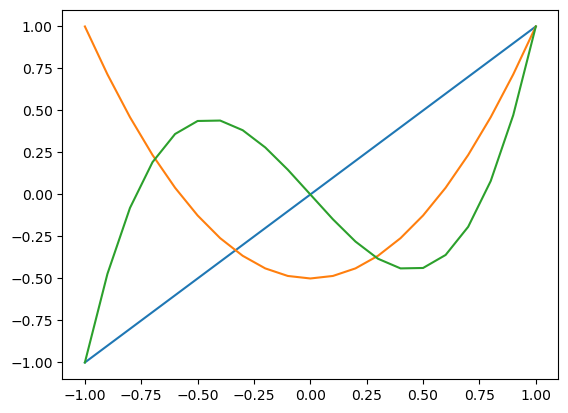

In [22]:
def y1(x):
    return x

def y2(x):
    return (3*x**2 - 1) / 2

def y3(x):
    return (5*x**3 - 3*x) / 2
x = np.linspace(-1,1,21)
plt.plot(x,y1(x))
plt.plot(x,y2(x))
plt.plot(x,y3(x))


In [23]:
def question_6(timesteps,t,a,e):
    J = 20
    n = J+1
    dx = 1 / J # stepsize
    dt = t # time increment
    k1 = dt*a / (dx)
    k2 = dt*e / ((dx)**2)
    theta = 0
    final_time = timesteps*dt
    left_boundary = 0
    right_boundary = 0

    A = np.zeros((n-2,n-2))
    b = np.zeros(n-2)
    u0 = np.zeros(n)
    f = np.linspace(-1,1,n)
    for i in range(n): # define the initial condition array
        u0[i] = u_0_2(f[i]) # references function above

    u = u0.copy()
    
    s1 = np.ones(n-3)*(theta*(-k1 - k2))
    s2 = np.ones(n-2)*(1 + theta*(k1 + 2*k2))
    s3 = np.ones(n-3)*(-k2*theta)
    q1 = k1 - k1*theta + k2 - k2*theta
    q2 = 1 - k1 + k1*theta - 2*k2 + 2*k2*theta
    q3 = k2*(1-theta)

    
    A = diags([s2,s3,s1], [0,1,-1])


    k = dt
    while k <= final_time:
        for i in range(n-2):
            b[i] = q3*u[i] + q2*u[i+1] + q1*u[i+2]
      
        b[0] += left_boundary*k2*theta
        b[n-3] += right_boundary*theta*(k1+k2)
    
        solution = spsolve(A,b)
        u[1:-1] = solution
        k+=dt
    
    return(u)

C:\Users\mm21jd\AppData\Local\Temp\ipykernel_16644\4002743892.py:41: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A,b)


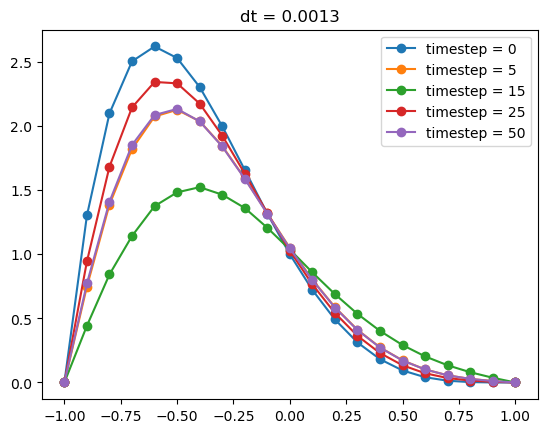

In [42]:
x = np.linspace(-1,1,21)
d1 = question_6(0,0.0013, 1,1)
d2 = question_6(5,0.0013, 1,1)
d3 = question_6(15, 0.0013, 1,1)
d4 = question_6(25,0.00013, 1,1)
d5 = question_6(50, 0.00013, 1,1)

plt.plot(x, d1, marker ='o', label='timestep = 0')
plt.plot(x,d2, marker ='o', label='timestep = 5')
plt.plot(x,d3, marker ='o',label='timestep = 15')
plt.plot(x,d4, marker ='o',label='timestep = 25')
plt.plot(x,d5, marker ='o',label='timestep = 50')
plt.title('dt = 0.0013')
plt.legend()
         

In [25]:
def question_7(timesteps,t,a,e):
    J = 20
    n = J+1
    dx = 1 / J # stepsize
    dt = t # time increment
    k1 = dt*a / (dx)
    k2 = dt*e / ((dx)**2)
    theta = 0
    final_time = timesteps*dt
    left_boundary = 0
    right_boundary = 0

    A = np.zeros((n-2,n-2))
    b = np.zeros(n-2)
    u0 = np.zeros(n)
    f = np.linspace(-1,1,n)
    for i in range(n): # define the initial condition array
        u0[i] = u_0_3(f[i]) # references function above

    u = u0.copy()
    
    s1 = np.ones(n-3)*(theta*(-k1 - k2))
    s2 = np.ones(n-2)*(1 + theta*(k1 + 2*k2))
    s3 = np.ones(n-3)*(-k2*theta)
    q1 = k1 - k1*theta + k2 - k2*theta
    q2 = 1 - k1 + k1*theta - 2*k2 + 2*k2*theta
    q3 = k2*(1-theta)

    
    A = diags([s2,s3,s1], [0,1,-1])


    k = dt
    while k <= final_time:
        for i in range(n-2):
            b[i] = q3*u[i] + q2*u[i+1] + q1*u[i+2]
      
        b[0] += left_boundary*k2*theta
        b[n-3] += right_boundary*theta*(k1+k2)
    
        solution = spsolve(A,b)
        u[1:-1] = solution
        k+=dt
    
    return(u)

C:\Users\mm21jd\AppData\Local\Temp\ipykernel_16644\2068608058.py:41: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A,b)


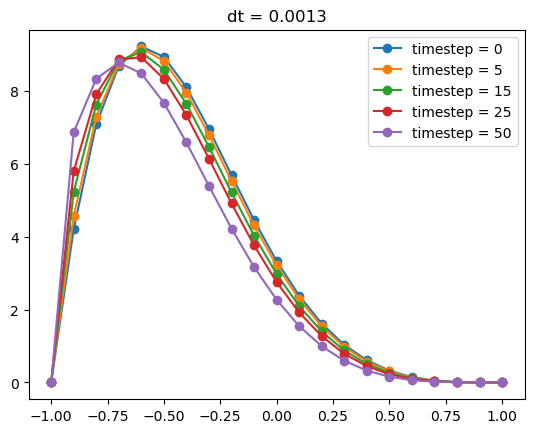

In [26]:
x = np.linspace(-1,1,21)
e1 = question_7(0,0.0013, 1,0.001)
e2 = question_7(5,0.0013, 1,0.001)
e3 = question_7(15, 0.0013, 1,0.001)
e4 = question_7(25,0.0013, 1,0.001)
e5 = question_7(50, 0.0013, 1,0.001)

plt.plot(x, e1, marker ='o', label='timestep = 0')
plt.plot(x,e2, marker ='o', label='timestep = 5')
plt.plot(x,e3, marker ='o',label='timestep = 15')
plt.plot(x,e4, marker ='o',label='timestep = 25')
plt.plot(x,e5, marker ='o',label='timestep = 50')
plt.title('dt = 0.0013')
plt.legend()